In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [36]:
# 1. Fetch the data for TSLA
data = yf.download('TSLA', start='2023-12-01', end='2024-12-01')

[*********************100%***********************]  1 of 1 completed


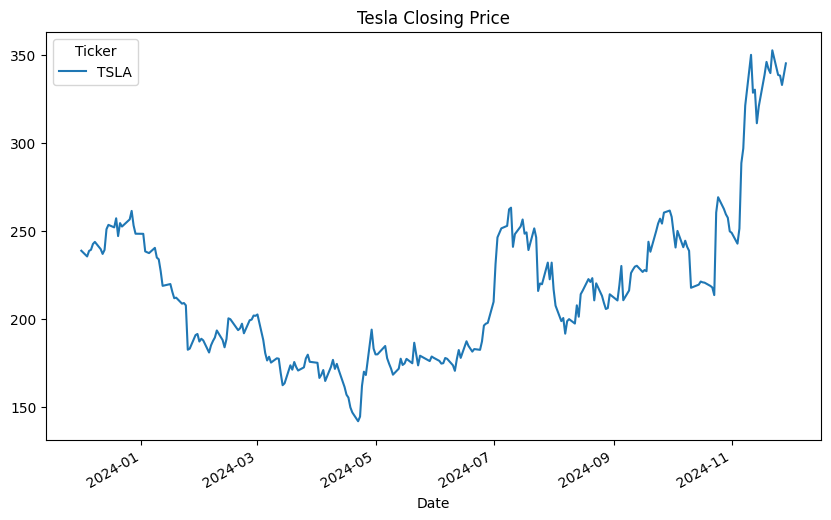

In [37]:
data['Close'].plot(title='Tesla Closing Price', figsize=(10, 6))
plt.show()

In [38]:
def make_stationary(data):
    diff = data.diff().dropna()  # Perform first differencing
    return diff

In [39]:
tsla_diff = make_stationary(data['Close'])

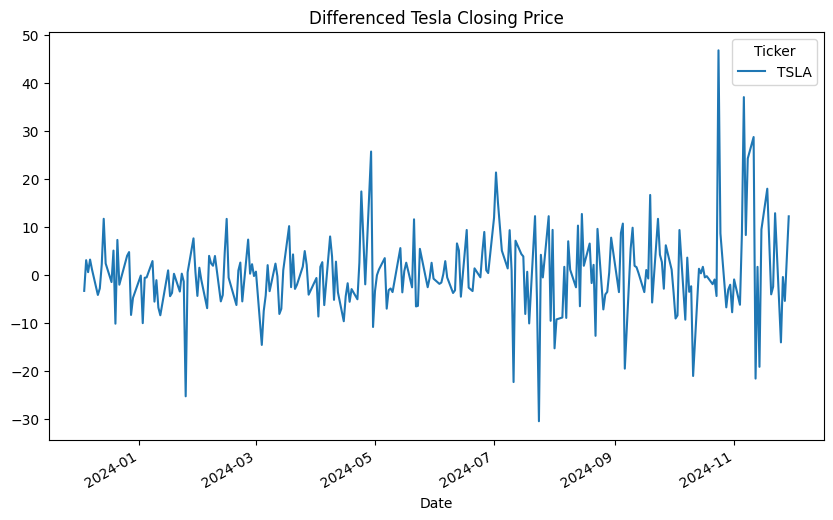

In [40]:
tsla_diff.plot(title='Differenced Tesla Closing Price', figsize=(10, 6))
plt.show()

In [41]:
adf_result = adfuller(tsla_diff)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
if adf_result[1] < 0.05:
    print('The series is stationary.')
else:
    print('The series is not stationary.')

ADF Statistic: -15.615983299237971
p-value: 1.7558357345756553e-28
The series is stationary.


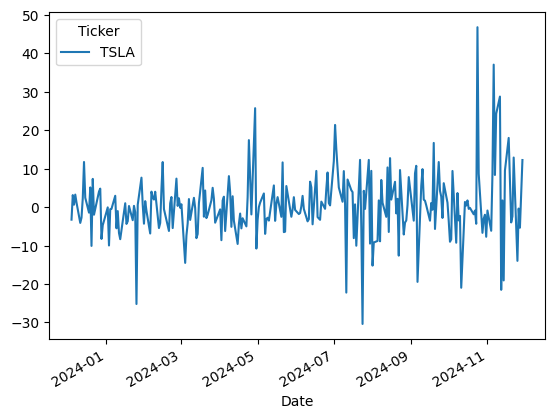

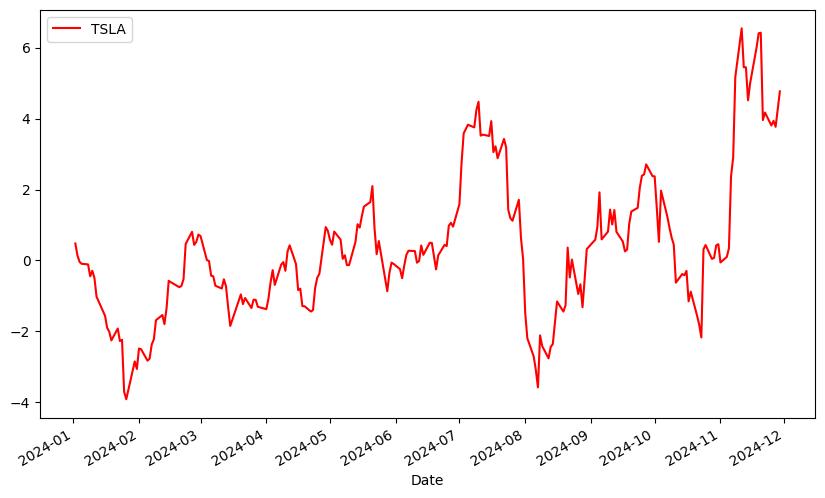

In [42]:
moving_avg = tsla_diff.rolling(window=20).mean()
tsla_diff.plot(label='Differenced Data')
moving_avg.plot(label='20-Day Moving Average', color='red', figsize=(10, 6))
plt.legend()
plt.show()

In [43]:
acf_vals = acf(tsla_diff, nlags=40)
pacf_vals = pacf(tsla_diff, nlags=40)

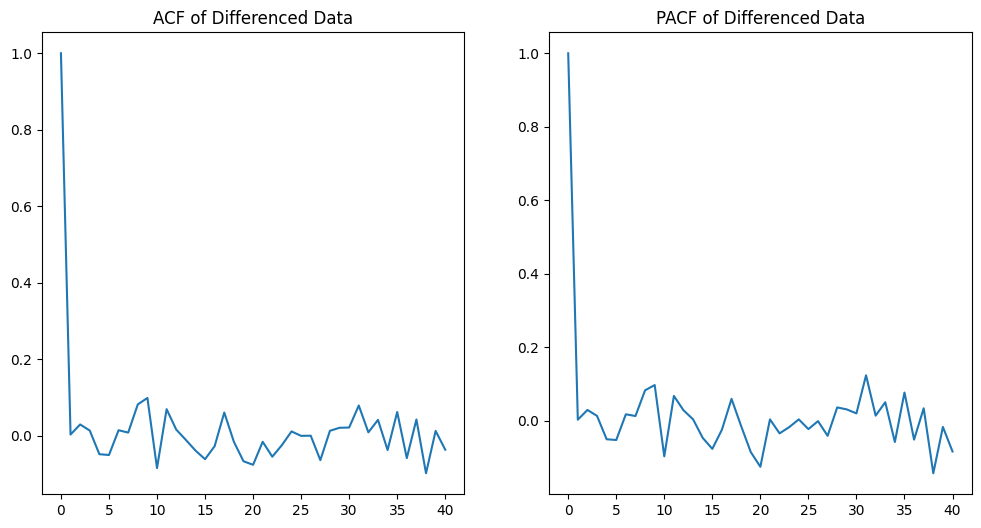

In [44]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(acf_vals)
plt.title('ACF of Differenced Data')

plt.subplot(122)
plt.plot(pacf_vals)
plt.title('PACF of Differenced Data')

plt.show()

In [78]:
p, d, q = 13, 1, 5  # example values

# 7. Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

In [79]:
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()


f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                  200
Model:                ARIMA(13, 1, 5)   Log Likelihood                -667.120
Date:                Tue, 17 Dec 2024   AIC                           1372.240
Time:                        16:38:25   BIC                           1434.813
Sample:                             0   HQIC                          1397.565
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1358      0.800     -0.170      0.865      -1.703       1.431
ar.L2          0.1815      0.455      0.399      0.690      -0.711       1.074
ar.L3          0.0275      0.445      0.062      0.9

In [81]:
forecast = model_fit.forecast(steps=len(test))

f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
f:\Elliot Systems\Learning Materials\pythonmodel\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


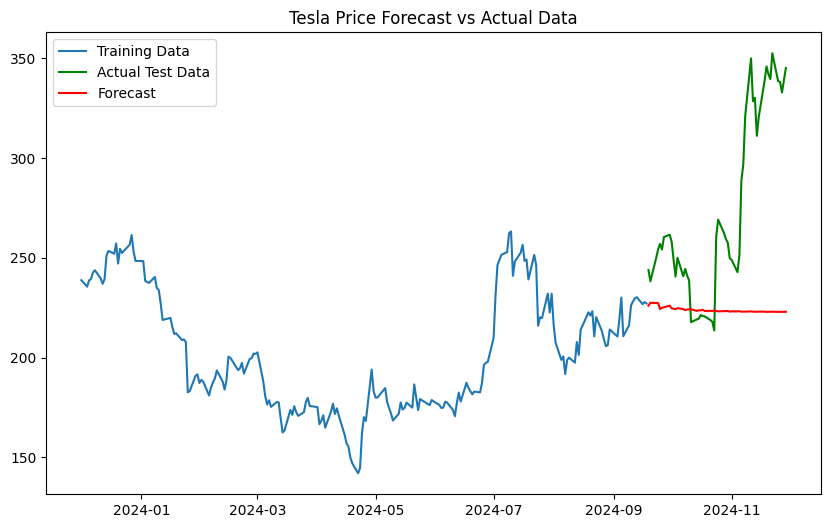

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Tesla Price Forecast vs Actual Data')
plt.show()

In [83]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

In [84]:
# Ensure forecast and test are 1D arrays of the same length
forecast_array = np.array(forecast).flatten()
test_array = np.array(test.values).flatten()

# Check if the shapes match
if forecast_array.shape != test_array.shape:
    raise ValueError(f"Shape mismatch: forecast shape {forecast_array.shape}, test shape {test_array.shape}")

# Calculate relative error
relative_error = np.abs((forecast_array - test_array) / test_array) * 100


In [85]:
mean_relative_error = np.mean(relative_error)
accuracy_percentile = 100 - mean_relative_error

In [86]:
# Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Relative Error: {mean_relative_error:.2f}%')
print(f'Model Accuracy: {accuracy_percentile:.2f}%')


Mean Absolute Error (MAE): 49.894713371100224
Root Mean Squared Error (RMSE): 66.0276736274801
Mean Relative Error: 16.36%
Model Accuracy: 83.64%
